## Обучение с учителем: качество модели

[yandex_practicum](https://practicum.yandex.ru/learn/data-scientist/courses/7003ed02-62c7-4cb8-96de-ac10f3bfb19e/sprints/197574/topics/69231b00-9a4c-4392-96e5-26994e6bcfd7/lessons/85fa7b7d-0060-44bb-bd83-ac26a345c91f/)

Почему нужны дополнительные модели для классификации?

Линейная и логистические регрессии прогнозируют целевой признак с помощью линейного уравнения. Такие модели хорошо работают <font color='red'>на качественных данных с линейной связью</font> . На практике специалисты часто имеют дело с нелинейной зависимостью и вовсе не идеальными датасетами — <font color='red'>с выбросами, недостатком наблюдений... </font> 

Чтобы помочь бизнесу при таких вводных, нужны другие модели машинного обучения.

Постановка задачи

Компания «Морские вкусняхи» доставляет корпоративным клиентам блюда из морепродуктов — устрицы, мидии и строганину из разных сортов рыб. На прибыль сильно влияет отмена заказов, потому что их не оплачивают, а товар приходится выбрасывать. Морепродукты нельзя замораживать повторно, иначе портится вкус. Менеджмент задумал отбивать себестоимость и ввести предоплату, но для этого необходима модель, которая будет предсказывать отмену заказов.

Опыт показывает, что эта мера отпугивает 20% клиентов. Решено запрашивать предоплату 70% в тех случаях, когда есть явный риск отмены заказа. Специалисту по Data Science — то есть вам — нужно научиться предсказывать такие случаи. При этом важно сэкономить больше 1 млн 100 тыс. рублей, чтобы окупить затраты на новое решение.

In [1]:
# библиотеки для работы с данными
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import random

# бибилотеки для подготовки данных
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# библиотеки для линейной регрессии
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# библиотеки для логистической регрессии
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score


# добавим библиотеку для построения scatter диаграмм рассеяния с тренд-линиями
import plotly.express as px 
import plotly.graph_objects as go

import math

In [2]:
data = pd.read_csv('/Users/tony_builder/Documents/GitHub/studying/yandex_practicum/8_supervised_learning/orders_seafood.csv')

In [3]:
data.head()

,client_id,reject_count,confirm_count,last_summ,summ_,count_position,target
0,8195,27,13,132684.4,34875.3,18,1
1,16392,29,15,149790.1,19537.4,11,1
2,16396,25,17,80195.2,44583.0,23,1
3,8206,22,10,80089.5,22561.6,15,1
4,16398,14,14,163565.6,27986.4,17,1


In [4]:
data.shape

(750, 7)

Информация о датасете

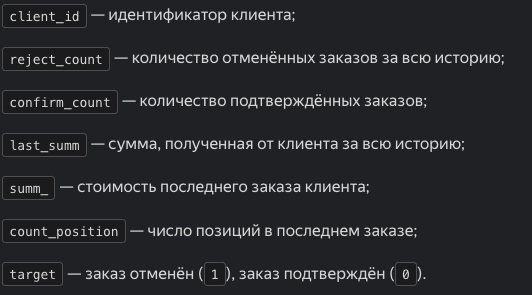

### Исследовательский анализ данных

In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
client_id,750.0,8911.952000,6815.642179,25.0,1030.25,8928.0,16768.00,17776.0
reject_count,750.0,20.524000,6.190896,5.0,16.00,21.0,25.00,39.0
confirm_count,750.0,43.281333,55.671117,5.0,14.00,17.0,24.75,204.0
last_summ,750.0,117236.968533,33535.611602,32896.4,98092.80,120045.1,142483.85,191564.8
summ_,750.0,13642.938933,11264.546470,1460.1,5028.40,8134.7,22788.95,69465.9
count_position,750.0,8.010667,6.231184,1.0,3.00,5.0,13.00,30.0
target,750.0,0.700000,0.458563,0.0,0.00,1.0,1.00,1.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       750 non-null    int64  
 1   reject_count    750 non-null    int64  
 2   confirm_count   750 non-null    int64  
 3   last_summ       750 non-null    float64
 4   summ_           750 non-null    float64
 5   count_position  750 non-null    int64  
 6   target          750 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 41.1 KB


In [7]:
numeric_columns = ['reject_count', 'confirm_count', 'last_summ', 'summ_', 'count_position']

categorical_columns = ['target']

In [8]:
dict_names = {'reject_count': 'число отмененных заказов',
              'confirm_count': 'число подтвержденных заказов',
              'last_summ': 'сумма заказов за всю историю',
              'summ_': 'сумма последнего заказа',
              'count_position': 'число позиций в последнем заказе',
              'target': 'статус заказа (отменен/ не отменен)'

}

Функция для построения гистограммы и boxplot для числовых признаков на одном графике. Причем гистограмма будет ограничена размерами усов. все выбросы мы сможем увидеть на box-plot

In [9]:
# функция гистограммы и boxplot на одном графике

def hist_boxplot(data, col, dataset_name, dict_names):
    df_for_plot= data[col]

    # Рассчитываем квантили
    q25, q75 = df_for_plot.quantile(0.25), df_for_plot.quantile(0.75)
    min_val = int(q25- 1.5*(q75-q25))
    max_val= int(q75 +  1.5*(q75-q25))

    # Создаем новый график
    plt.figure(figsize=(10, 6))

    # Строим гистограмму
    plt.subplot(2, 1, 1)  # 2 строки, 1 столбец, график 1
    plt.hist(df_for_plot, bins=20, range=(min_val, max_val))
    plt.title(f'Гистограмма датасета {dataset_name} для признака {dict_names[col]}')
    plt.xlabel(f'значения признака {dict_names[col]}')
    plt.ylabel(f'Частота')


    # Помечаем квартили на гистограмме
    plt.axvline(q25, color='r', linestyle='--', label='25th percentile')
    plt.axvline(q75, color='g', linestyle='--', label='75th percentile')
    plt.legend()

    # Строим график boxplot
    plt.subplot(2, 1, 2)  # 2 строки, 1 столбец, график 2
    plt.boxplot(df_for_plot, vert=False)
    plt.title(f'Boxplot признака {dict_names[col]} ')
    plt.xlabel(f'Значение признака {dict_names[col]}')

    # Помечаем квартили на boxplot
    plt.axvline(q25, color='r', linestyle='--', label='25th percentile')
    plt.axvline(q75, color='g', linestyle='--', label='75th percentile')
    plt.legend()


    # Показываем графики
    plt.tight_layout()  # Для автоматического выравнивания графиков
    plt.show()


        

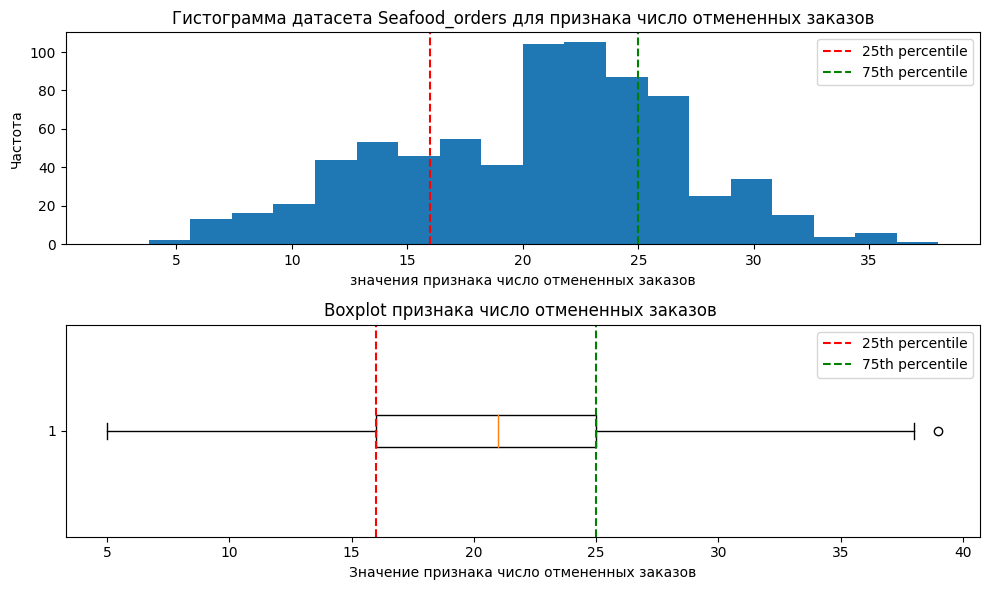

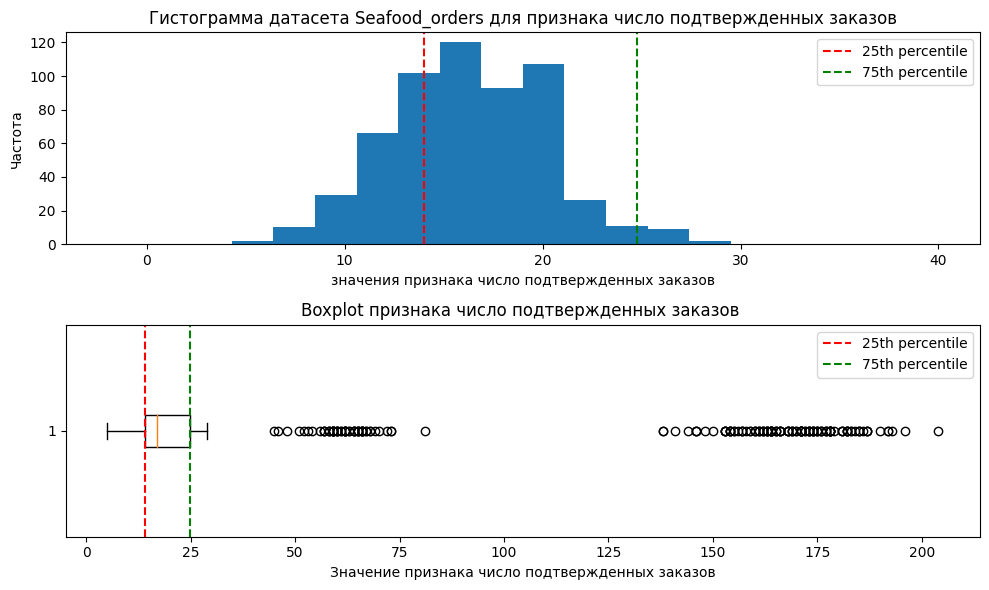

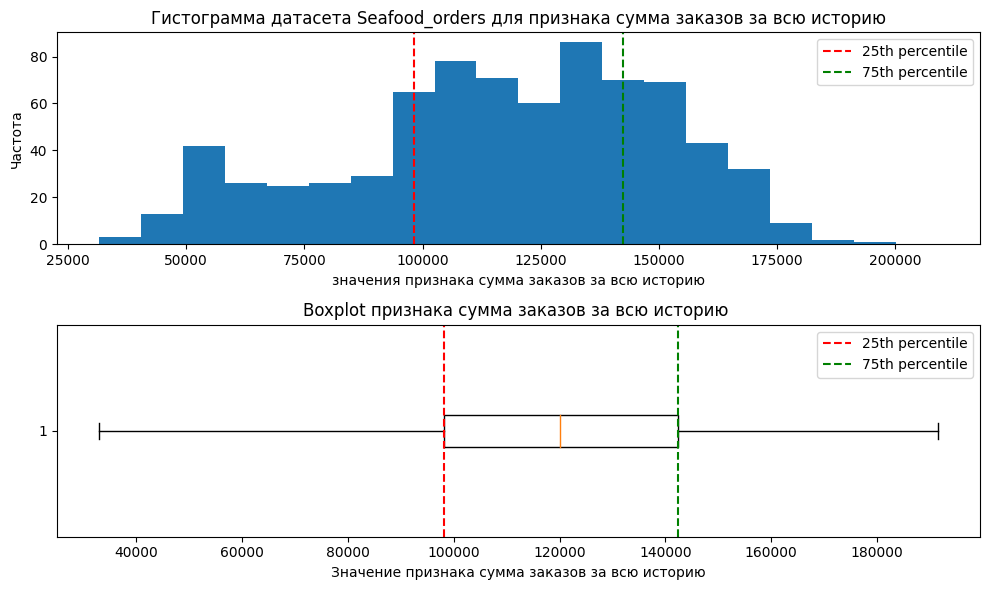

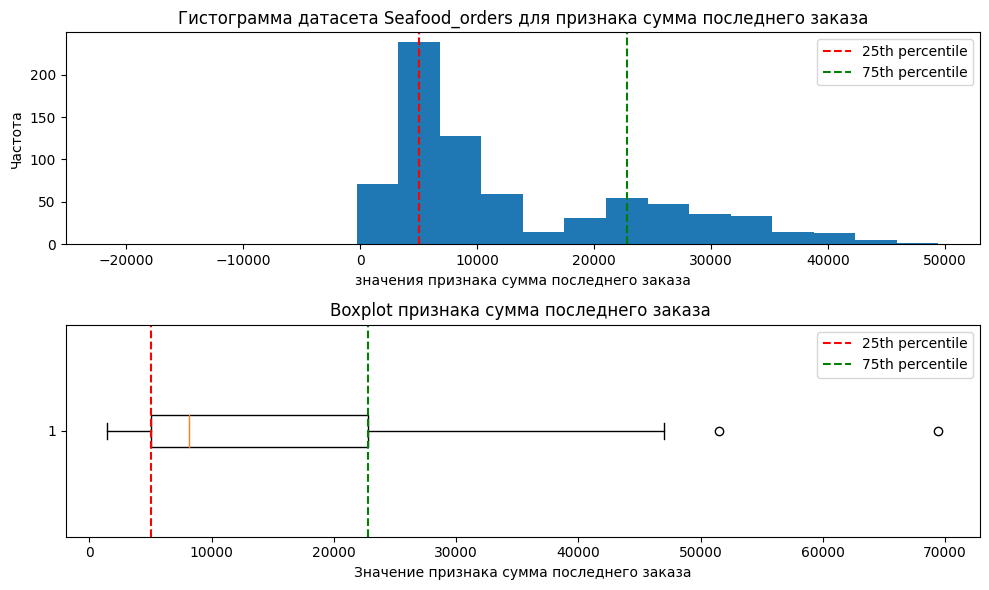

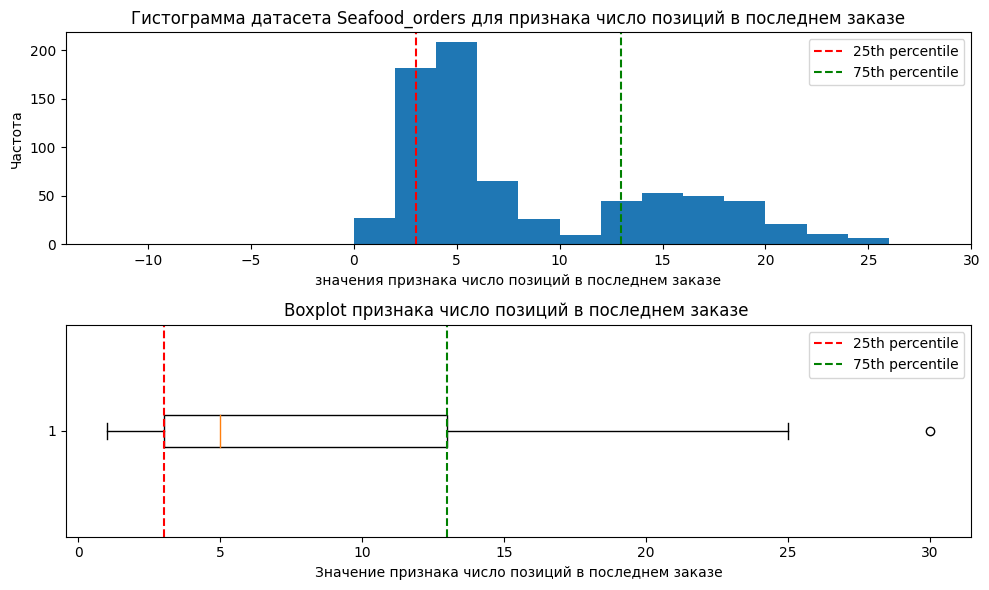

In [10]:
for col in numeric_columns:
    hist_boxplot(data=data, col=col, dataset_name ='Seafood_orders', dict_names=dict_names)

Функция для построения столбчатых диаграмм для категориальных признаков

In [11]:
def bar_plot(data, col, dataset_name, dict_names):
    try:
        data[col].value_counts().plot(kind='bar', legend=True, figsize=(10,5))
        plt.title(f'Диаграмма частоты признака {dict_names[col]} датасета {dataset_name}')
        plt.xlabel(f'значение признака {dict_names[col]}')
        plt.ylabel(f'Частота признака {dict_names[col]}')
        plt.show()
        
    except KeyError:
        print(f'Признак {dict_names[col]} не может быть описан столбчатоый диаграммой')

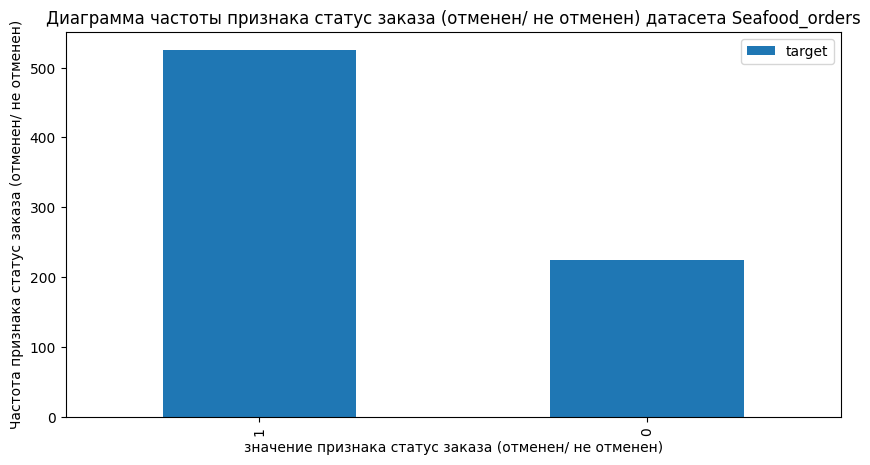

In [12]:
for col in categorical_columns:
    bar_plot(data=data, col=col, dataset_name='Seafood_orders', dict_names= dict_names)

### Работа с моделью линейной регрессии

#### Подготовка данных и Обучение модели

In [13]:
RANDOM_STATE = 77

X = data.drop(columns=['target', 'client_id'])
y = data['target'] 

scaler = StandardScaler()

X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
X_train_scalled = scaler.fit_transform(X_train)
X_test_scalled = scaler.transform(X_test)

clf = LogisticRegression()
clf = clf.fit(X_train_scalled, y_train)
y_pred = clf.predict(X_test_scalled) 


r = accuracy_score(y_test, y_pred)

print(r)

0.648936170212766


А вдруг точности в 65% достаточно, чтобы выполнить запрос бизнеса и сэкономить 1 млн 100 тыс. рублей? 

Для проверки предлагаем сделать приблизительный расчёт на тестовой выборке: 
1) Сначала вычислить, сколько компании удалось бы сберечь благодаря модели. Для этого нужно умножить стоимость отменённых заказов, которые удалось предсказать, на 70% — размер предоплаты. Но важно учесть, что 20% клиентов из-за нового требования изначально не оформили бы заказ — соответственно, предоплату не внесли бы. Поэтому рассчитанную сумму выгоды нужно умножить ещё и на 80%, чтобы её уточнить. То есть слегка уменьшить.

2) Потом найти сумму, которую компания потеряла бы из-за модели. Чтобы её выяснить, тоже важна статистика об уходе пятой части клиентов из-за запроса на предоплату. Надо умножить на 20% стоимость заказов, отмена которых не подтвердилась. Ведь их могли бы оплатить, если бы никого не смутило новое требование.
3) Вычесть из сбережённой суммы объём потерь.

In [14]:
predicts = X_test[['summ_']]
predicts['y_pred'] = y_pred
predicts['y_test'] = y_test

TP = predicts.loc[(y_pred==1)&(y_test==1), 'summ_'].sum()*0.7*0.8
FP = predicts.loc[(y_pred==1)&(y_test==0), 'summ_'].sum()*0.2

money = TP-FP
print(money)

1066557.42


/var/folders/9t/0d2y6zvs0pn1b5hks81yn5jw0000gn/T/ipykernel_4005/3228329572.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicts['y_pred'] = y_pred
/var/folders/9t/0d2y6zvs0pn1b5hks81yn5jw0000gn/T/ipykernel_4005/3228329572.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicts['y_test'] = y_test


Результат: с нынешней моделью для наблюдений тестовой выборки получилось сэкономить около 1 млн 66 тыс. рублей. Чтобы окупить расходы на внедрение машинного обучения, надо «выиграть» больше.

#### Настройка модели с помощью порогов

In [15]:
import numpy as np

thresholds = [round(i,2) for i in np.linspace(0.1,1,num = 12,endpoint=False)]
y_proba_log = clf.predict_proba(X_test_scalled)[:,1]

for i in thresholds:
    y_pred_log = []
    for j in y_proba_log:
        if j<i:
            y_pred_log.append(0)          
        else:
            y_pred_log.append(1) 
    predicts = pd.DataFrame(zip(y_pred_log, y_test,  X_test['summ_'].tolist()), \
                        columns = ['y_pred', 'y_test', 'summ_'])
    TP = predicts[(predicts['y_pred']==1)&(predicts['y_test']==1)]['summ_'].sum()*0.7*0.8
    FP = predicts[(predicts['y_pred']==1)&(predicts['y_test']==0)]['summ_'].sum()*0.2
    money = TP-FP
    print('threshold: ', i, '   money: ',money)

threshold:  0.1    money:  1089660.98
threshold:  0.18    money:  1089660.98
threshold:  0.25    money:  1089660.98
threshold:  0.32    money:  1089660.98
threshold:  0.4    money:  1087737.372
threshold:  0.48    money:  1080149.3480000002
threshold:  0.55    money:  1049577.9239999999
threshold:  0.62    money:  1022793.4440000001
threshold:  0.7    money:  982374.764
threshold:  0.77    money:  941061.4520000002
threshold:  0.85    money:  858757.1720000001
threshold:  0.92    money:  574174.244


#### Так в чем же дело?

В датасете есть выбросы — не аномальные, но нестандартные комбинации входных и целевых признаков. 

Посмотрим на график зависимости целевого признака от входных, разбитых по парам. 

На нём видно, как распределились отменённые и подтверждённые заказы при разных значениях входных признаков. 

Как видите, ни на одном из изображений нет чёткой границы между отменёнными заказами — оранжевыми кружками — и подтверждёнными — кружками синими. Каждый синий кружок среди большого количества оранжевых — и наоборот — это и есть свидетельство нестандартной комбинации признаков. Необычные значения целевого признака, которые мешают линейной модели учиться. И которые сложно предсказать.

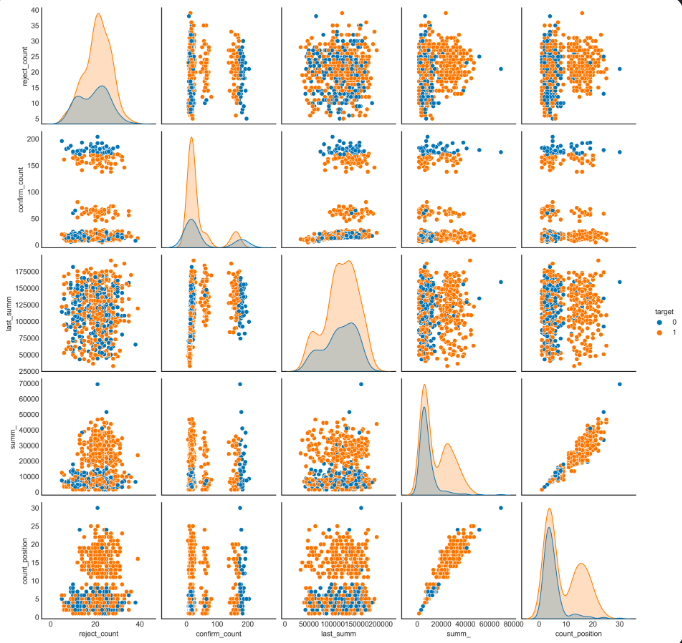

Строим scatter matrix в библиотеке seaborn с заголовком + выводим без дурацкой текстовой строки сверху

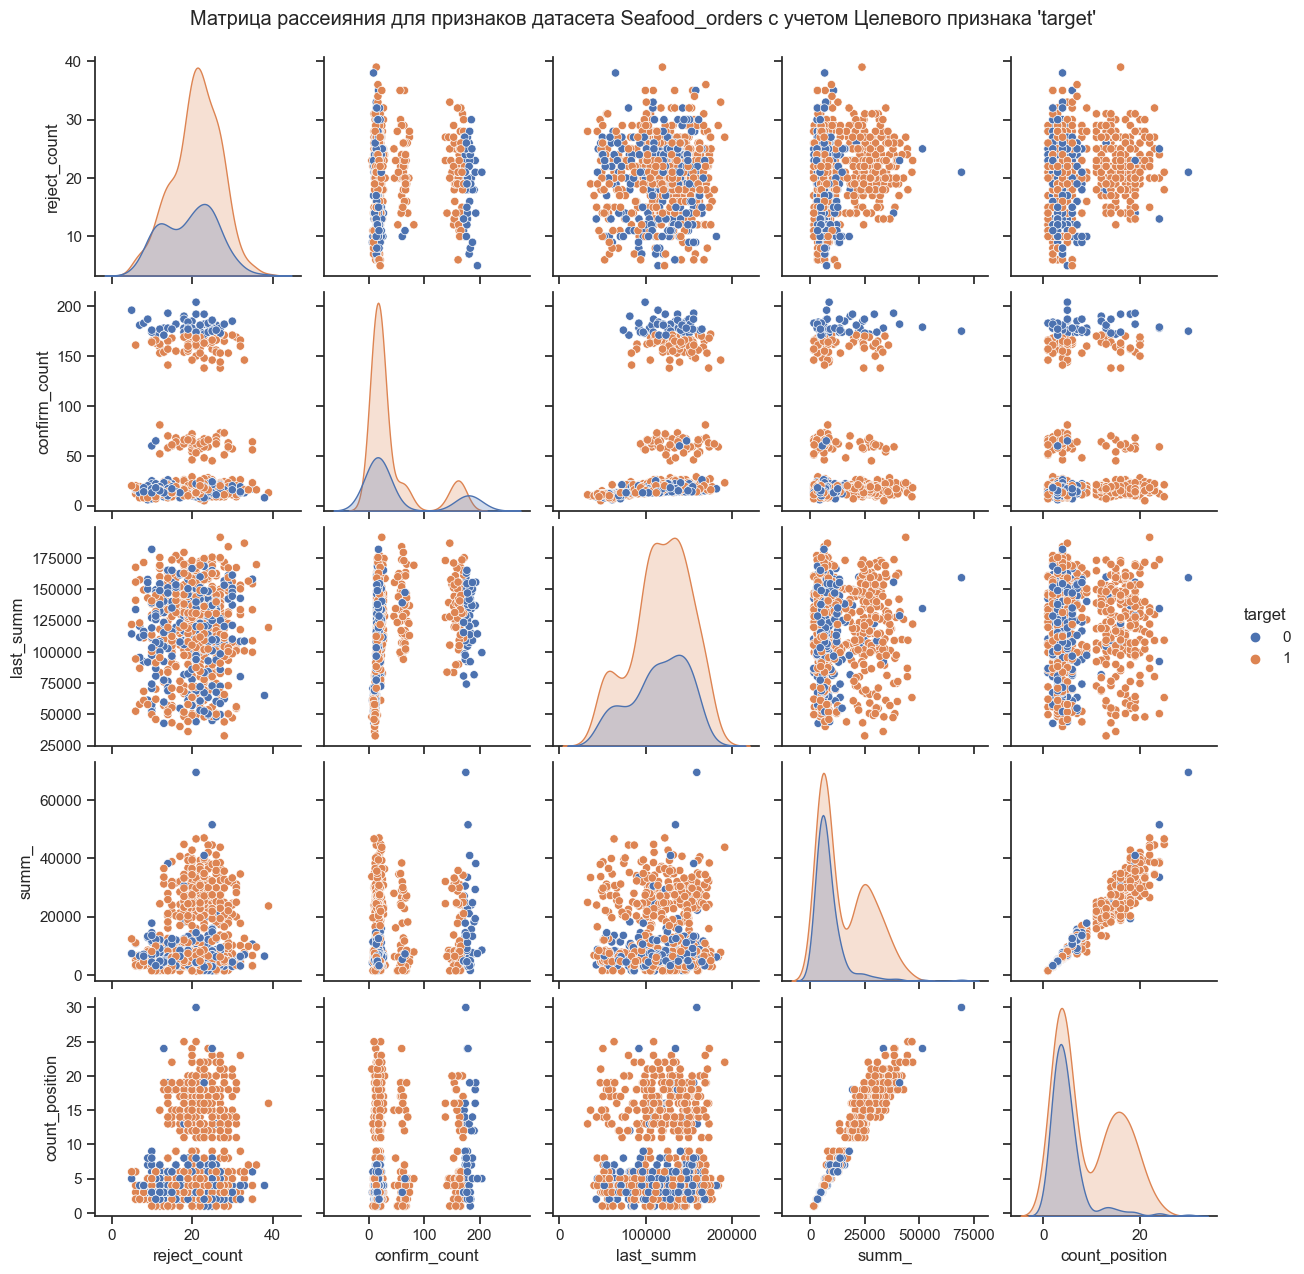

In [16]:

sns.set_theme(style="ticks")

sns.pairplot(data.drop('client_id', axis=1), 
             hue="target")


plt.suptitle(f"Матрица рассеияния для признаков датасета Seafood_orders с учетом Целевого признака 'target' ",
             y = 1.02)

# Показываем график
plt.show()

Удалять аномальные выбросы нельзя, ведь заказчик попросил учесть информацию о нестандартных клиентах и заказах, чтобы делать предсказания в разных ситуациях.

#### Выводы
Линейная и логистическая регрессии хорошо работают на данных с сильной <font color='red'>линейной зависимостью</font>  между целевым и входными признаками.

Нужно использовать другую модель классификации

### Урок 1. Модель «Метод опорных векторов»

#### Базовое понятие

Что такое выброс и что аномалия?

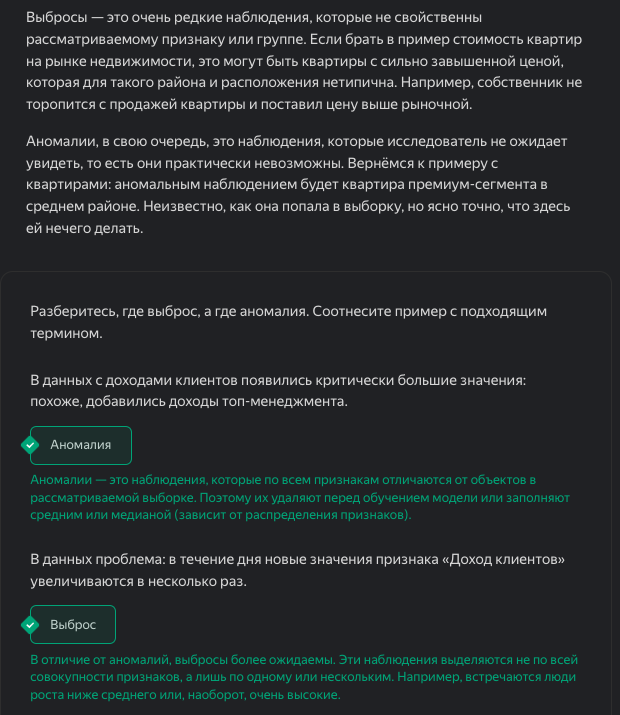

Понятие метода опорных векторов

Вернёмся к проблеме с моделями. Напомним: логистическая регрессия не справляется с классификацией из-за выбросов. Поэтому специалисты по DS придумали строить прямую не ближе всего к точкам наблюдений, а как можно дальше от границ двух классов. Получилась робастная модель под названием «Метод опорных векторов» (англ. support vector machine, SVM). 

Другой принцип обучения позволяет этой модели обходить выбросы стороной — буквально.

Построить прямую подальше от границ разных классов — значит провести её с максимальным зазором между крайними точками каждого из них:

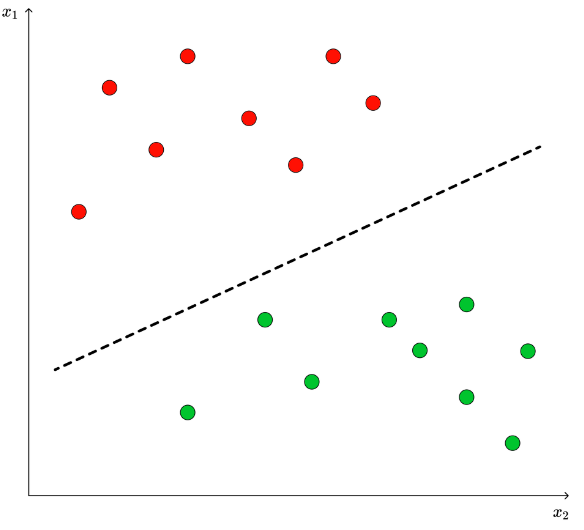

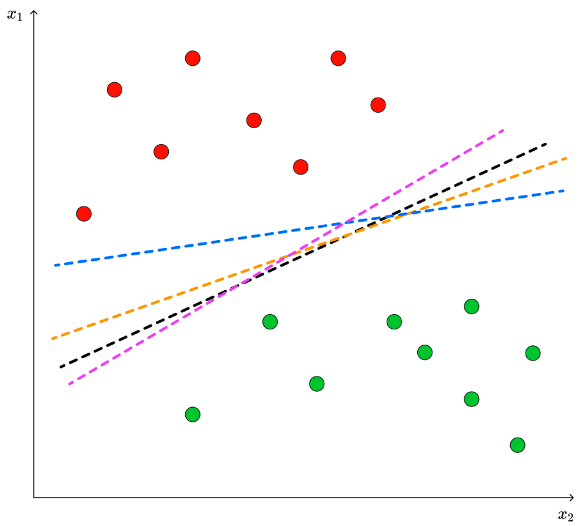

Выбор прямой, разделяющей классы

Лучшей среди прямых будет та, что находится на одинаково максимальном расстоянии между двумя классами. Определить это расстояние, или зазор, помогут ближайшие к «спорной» зоне точки-наблюдения из обоих классов.

        Их называют опорными векторами, благодаря им модель и получила своё название.


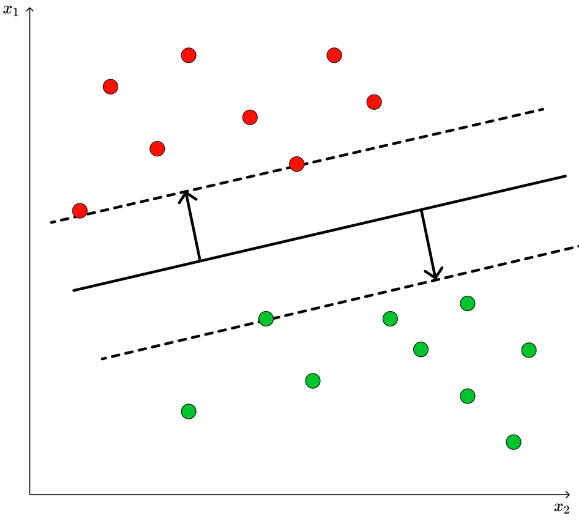

Выбор наилучшего варианта проведения прямой (или гиперплоскости)

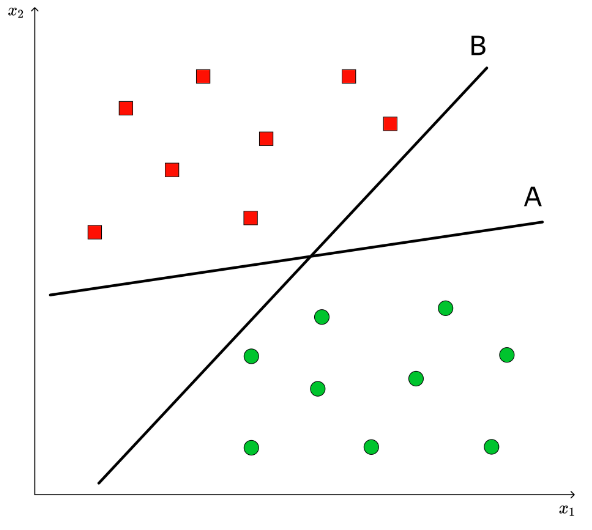

        лучше вариант A. 

Чтобы хорошо разграничить классы, между гиперплоскостью и каждым из классов должно быть как можно больше места. Так модель будет реже ошибаться с новыми наблюдениями, которые могут выйти за узкие рамки и ошибочно залезть на территорию другого класса. 

Этим SVM отличается от логистической регрессии — <font color='red'>логрег подстраивается под каждое наблюдение, а не под класс в целом.</font> 

#### Математическая основа метода опорных векторов

Принцип работы 

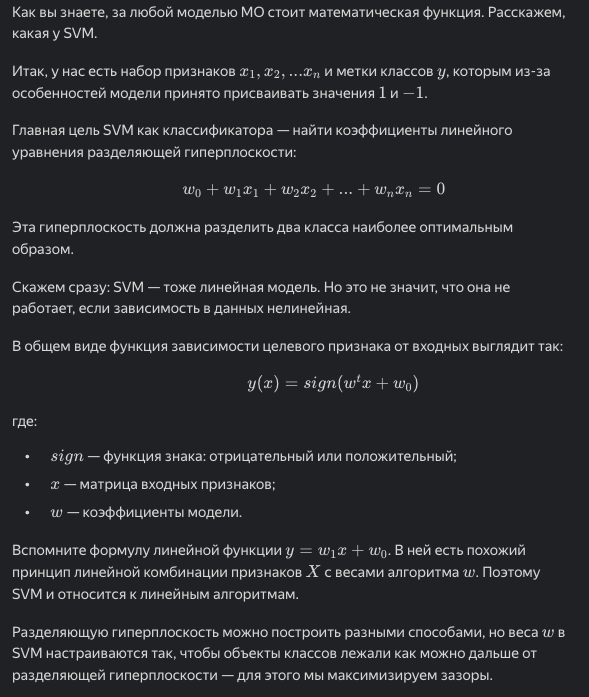

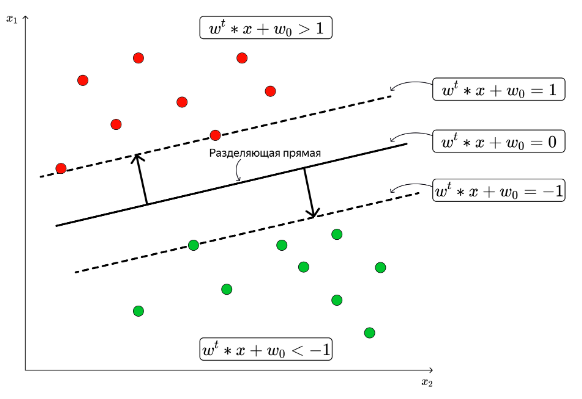

Итак, для решения задачи нужно, чтобы выполнялись два условия: 
- Прямая (или гиперплоскость) должна разделять классы как можно лучше, то есть расстояния от прямой до классов должны быть максимальными.

- Модель должна ошибаться как можно реже или не ошибаться вовсе (в лучшем случае).

Максимизируем зазор

Чтобы задать максимальный зазор, нужно посчитать расстояние от опорной точки-наблюдения до разделяющей прямой.

Напомним определение:

Расстояние от точки до прямой — это длина перпендикуляра, опущенного из этой точки на прямую.

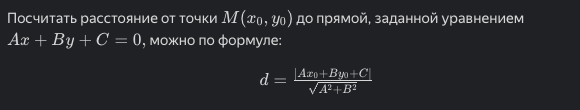

Поиск ширины "зазора" для общего случая

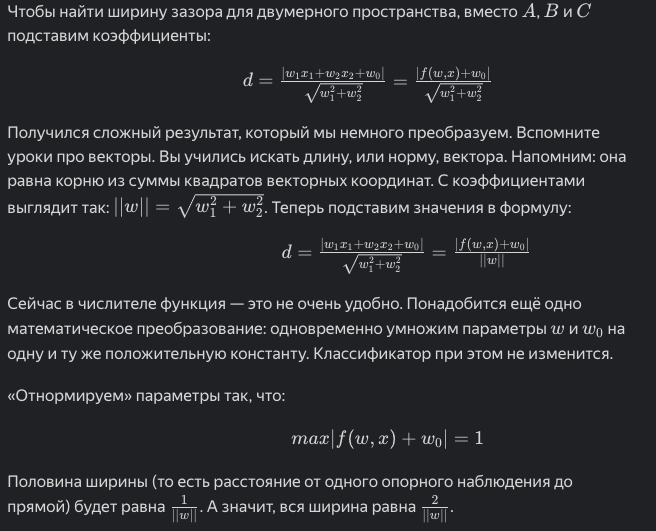

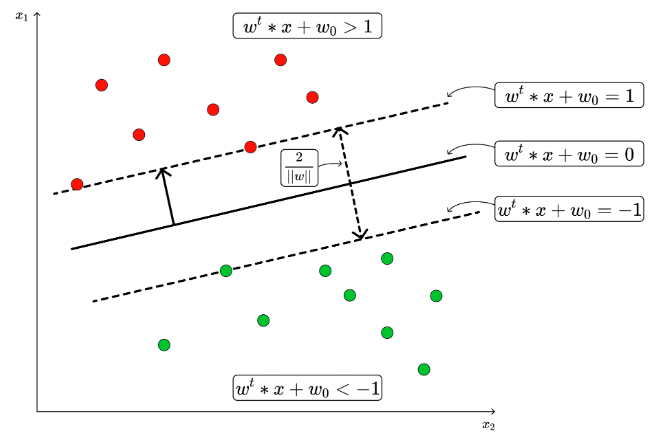

Цель - сделать зазор максимальным:

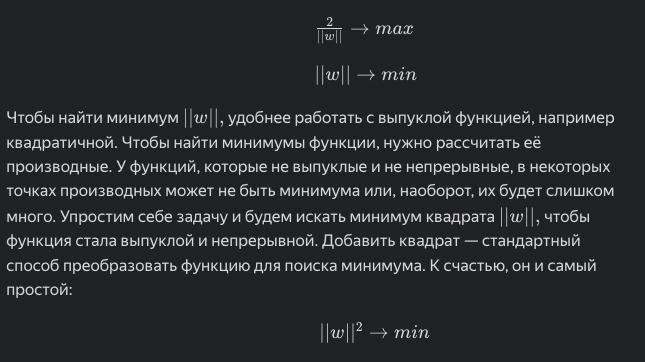

Работаем с ошибками модели

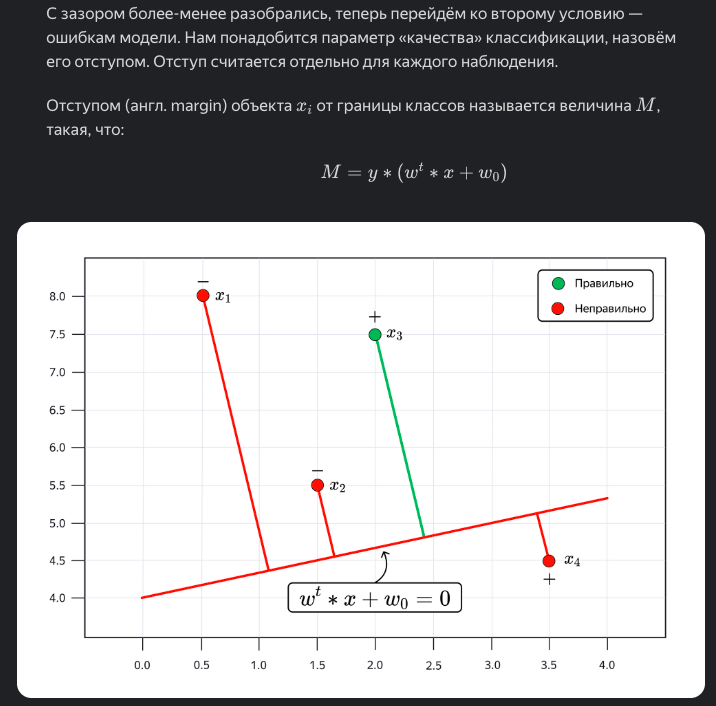

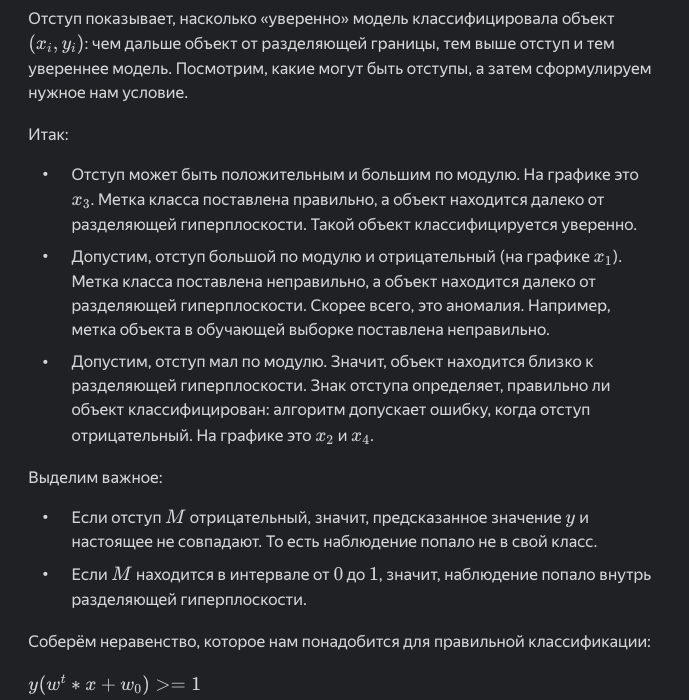


<font color='red'>
Выделим важное:

- Если отступ 
M отрицательный, значит, предсказанное значение 
y и настоящее не совпадают. То есть наблюдение попало не в свой класс.

- Если 
M находится в интервале от 
0 до 
1, значит, наблюдение попало внутрь разделяющей гиперплоскости.

</font>

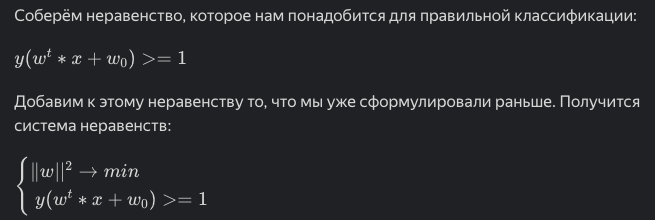

Что делать, когда данные точно не разделятся идеально?

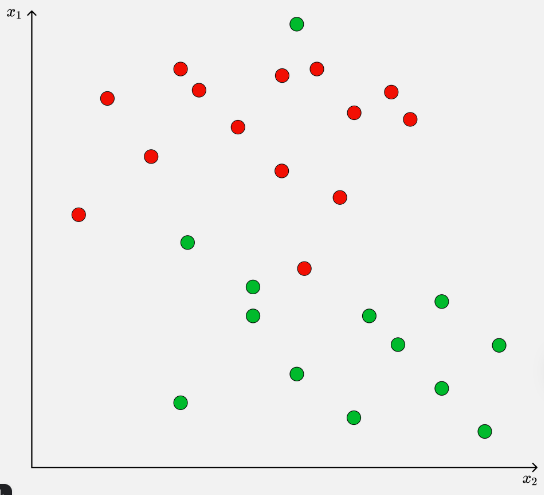

Нужно признать, что алгоритм будет ошибаться. Текущая система неравенств не допускает таких ошибок, ведь отступ всегда должен быть больше одного или равен одному. Позволим модели допускать ошибки, но сделаем так, чтобы их было как можно меньше.

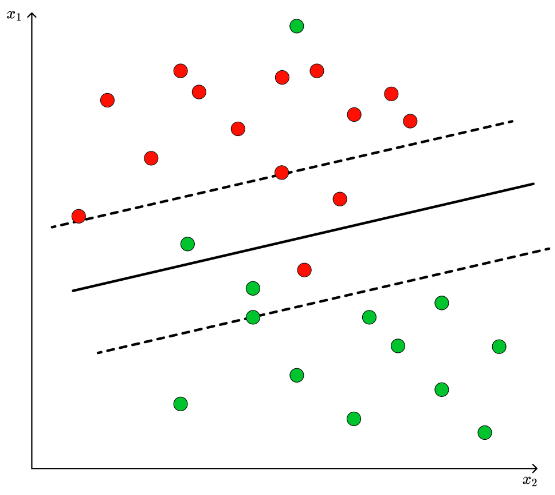

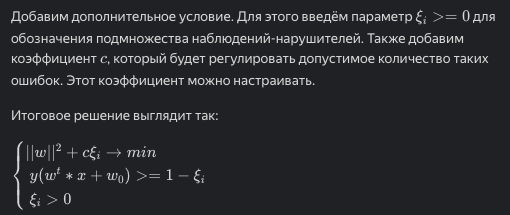

Такой зазор называют «мягким» (англ. soft margin). Он зависит от количества объектов-нарушителей: чем больше нарушителей мы допускаем, тем шире зазор, но больше ошибок при обучении. Широкий зазор строят в случае, когда данные сложно разделить линейно. Он помогает модели быть менее чувствительной к выбросам.

Выводы
- Логистическая регрессия не может работать с выбросами: она «подстраивается» под все данные, и потому при наличии выбросов решение будет сдвинуто в сторону неверных наблюдений.

- Бывает, что выбросы удалить невозможно. Тогда используют другие модели классификации, например метод опорных векторов.
Принцип работы метода такой — максимизировать расстояние между классами, проводя разделяющую прямую или гиперплоскость.

####  Метод опорных векторов python (SVM в scikit-learn)

Вернемся к данным по ресторану морепродуктов

In [17]:
data.head()

,client_id,reject_count,confirm_count,last_summ,summ_,count_position,target
0,8195,27,13,132684.4,34875.3,18,1
1,16392,29,15,149790.1,19537.4,11,1
2,16396,25,17,80195.2,44583.0,23,1
3,8206,22,10,80089.5,22561.6,15,1
4,16398,14,14,163565.6,27986.4,17,1


Модель SVC (от англ. support vector classification — «классификация опорных векторов») используется для задач классификации. 

Получается, что есть и другая? Да, SVR (от англ. support vector regression — «регрессия опорных векторов»). 

Последнюю мы пока рассматривать не будем, ведь для нашей задачи нужна именно SVC.

In [18]:
from sklearn.svm import SVC

clf = SVC()

X = data.drop(columns=['target', 'client_id'])
y = data['target']

X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
X_train_scalled = scaler.fit_transform(X_train)
X_test_scalled = scaler.transform(X_test)

clf = SVC()

clf.fit(X_train_scalled, y_train)
y_pred = clf.predict(X_test_scalled)

r = accuracy_score(y_test, y_pred)
print(r)

0.7180851063829787


Качество модели Метода опорных векторов выше - у логистической регрессии точность была 0.65

Теперь считаем потерянные деньги

In [19]:
# создаём таблицы для подсчёта средств, которые удалось сэкономить
predicts = X_test[['summ_']].copy()
predicts['SVM'] = y_pred
predicts['y_test'] = y_test

TP = predicts.loc[(y_pred==1)&(y_test==1), 'summ_'].sum()*0.7*0.8
FP = predicts.loc[(y_pred==1)&(y_test==0), 'summ_'].sum()*0.2

money = TP-FP
print(money)

1111647.992


Логрег позволяла экономить 1 089 660.98 руб при настройке порогов , а Метод опоорных векторов - 1,11 млн

В точности мы действительно выиграли

####  Построение гиперплоскости

In [20]:
# ставим библиотеку для построения гиперплоскости
# !pip3 install mlxtend

In [21]:
# Импортируем функцию plot_decision_regions, которая отрисует разделяющую границу:

from mlxtend.plotting import plot_decision_regions 

In [22]:
# поставить модуль в нужную версию python - через консоль!!!
#python3.10 -m pip install mlxtend

In [23]:
# посмотреть все модули , посмотреть все пакеты, которые установлены в python
# но запускать отдельной строкой!!!! без комментариев!!!

# pip freeze